In [1]:
# STEP 1: IMPORTING THE LIBRARIES

In [3]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 3.4 MB/s eta 0:00:17
   - -------------------------------------- 1.6/56.8 MB 4.0 MB/s eta 0:00:14
   - -------------------------------------- 2.4/56.8 MB 3.8 MB/s eta 0:00:15
   -- ------------------------------------- 3.1/56.8 MB 4.0 MB/s eta 0:00:14
   -- ------------------------------------- 3.9/56.8 MB 4.0 MB/s eta 0:00:14
   --- ------------------------------------ 4.7/56.8 MB 4.0 MB/s eta 0:00:14
   --- ------------------------------------ 5.5/56.8 MB 3.8 MB/s eta 0:00:14
   ---- ----------------------------------- 6.3/56.8 MB 3.8 MB/s eta 0:00:14
   ---- ----------------------------------- 7.1/56.8 MB 3.8 MB/s eta 0:00:14
   ----- ---------------------------------- 8.1/56.8 MB 3.8 MB/s eta 0:00:13
   ------ --------------------------------- 8.9/56.8 MB 3.8 MB/s eta 0:00:13
   ------ --------------------------------- 9.7/56.8 MB 3.8 MB/s eta 0:00:13
   --

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# For XGBoost
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [3]:
# STEP 2: LOADING THE DATASET

In [1]:
air_aware_data = pd.read_csv(r"C:\Users\Dell\Downloads\Air_Quality\main\Dataset_AQI4-5 - Copy.csv")

<IPython.core.display.Javascript object>

In [2]:
# Convert 'Date' or 'Datetime' column to datetime
# If your file has a 'Date' column (like city_day.csv in the India AQI dataset)
air_aware_data['Time'] = pd.to_datetime(air_aware_data['Time'], dayfirst=True, errors='coerce')
air_aware_data.rename(columns={'Time': 'timestamp'}, inplace=True)

<IPython.core.display.Javascript object>

In [3]:
print(air_aware_data.columns)
air_aware_data.head()

Index(['City', 'AQI', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'Latitude',
       'Longitude', 'timestamp'],
      dtype='object')


,City,AQI,PM2.5,PM10,O3,NO2,SO2,CO,Latitude,Longitude,timestamp
0,"Gulzarpet, Anantapur, India",88,88.0,71.0,26.3,4.6,2.4,6.5,14.675886,77.593027,2024-04-05 18:00:00
1,"Anand Kala Kshetram, Rajamahendravaram, India",58,58.0,45.0,14.6,12.0,6.9,6.7,16.987287,81.736318,2024-04-05 18:00:00
2,"Tirumala-APPCB, Tirupati, India",110,110.0,53.0,15.0,13.8,1.8,9.0,13.670000,79.350000,2024-04-05 18:00:00
3,"PWD Grounds, Vijayawada, India",-,52.0,NaN,5.1,0.7,4.9,4.2,16.507014,80.627767,NaT
4,"Naharlagun, Naharlagun, India",53,53.0,18.0,1.0,1.1,1.6,2.4,27.103358,93.679645,2024-04-05 09:00:00


In [5]:
print("Info:")
display(air_aware_data.info())

print("Missing values per columns:")
display(air_aware_data.isnull().sum())

print("Descriptive stats:")
display(air_aware_data.describe(include='all').T)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       153 non-null    object 
 1   AQI        151 non-null    float64
 2   PM2.5      147 non-null    float64
 3   PM10       136 non-null    float64
 4   O3         133 non-null    float64
 5   NO2        140 non-null    float64
 6   SO2        136 non-null    float64
 7   CO         133 non-null    float64
 8   Latitude   153 non-null    float64
 9   Longitude  153 non-null    float64
 10  Time       152 non-null    object 
dtypes: float64(9), object(2)
memory usage: 13.3+ KB


None

Missing values per columns:


City          0
AQI           2
PM2.5         6
PM10         17
O3           20
NO2          13
SO2          17
CO           20
Latitude      0
Longitude     0
Time          1
dtype: int64

Descriptive stats:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
City,153,138,"Sector 22, Chandigarh, India",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AQI,151.0,NaN,NaN,NaN,107.178808,80.312729,7.0,65.0,90.0,150.5,864.0
PM2.5,147.0,NaN,NaN,NaN,107.034014,72.90944,10.0,65.0,91.0,149.5,760.0
PM10,136.0,NaN,NaN,NaN,75.176471,74.242733,4.0,53.0,64.0,84.25,864.0
O3,133.0,NaN,NaN,NaN,18.830827,22.275973,0.1,5.7,14.1,25.2,220.6
NO2,140.0,NaN,NaN,NaN,9.331429,17.800332,0.1,2.375,5.4,10.5,198.0
SO2,136.0,NaN,NaN,NaN,9.830882,14.282019,0.1,3.6,5.3,10.9,124.4
CO,133.0,NaN,NaN,NaN,6.801504,6.189935,0.3,3.8,5.7,7.9,51.0
Latitude,153.0,NaN,NaN,NaN,24.19184,7.923528,8.514909,20.007328,25.204762,28.406963,53.58904
Longitude,153.0,NaN,NaN,NaN,77.217768,22.282424,-123.005934,75.9052,77.984321,84.663264,142.94797


In [6]:
# Handle missing values, duplicates, and wrong data

In [7]:
# Drop duplicates
air_aware_data.drop_duplicates(inplace=True)

In [8]:
pollutant_cols = ['AQI', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']

# covert columns to numeric, coercing errors to NaN
for col in pollutant_cols:
    air_aware_data[col] = pd.to_numeric(air_aware_data[col] ,errors = 'coerce')

# Fill missing numeric values with median
for col in pollutant_cols:
    median_val = air_aware_data[col].median()
    air_aware_data[col].fillna(median_val)

# remove negative values if any
for col in pollutant_cols:
    air_aware_data = air_aware_data[air_aware_data[col] >= 0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# Exploratory Data Analysis(EDA)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

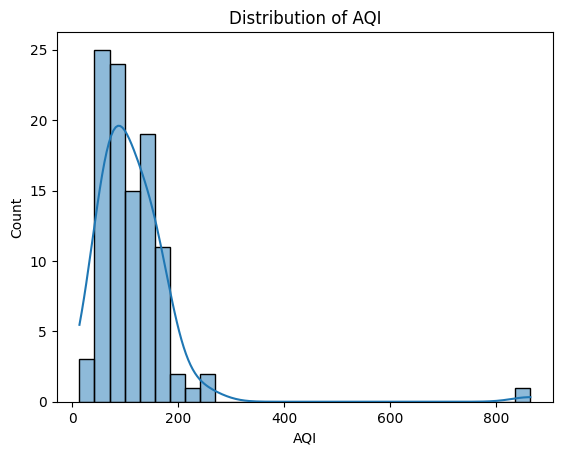

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

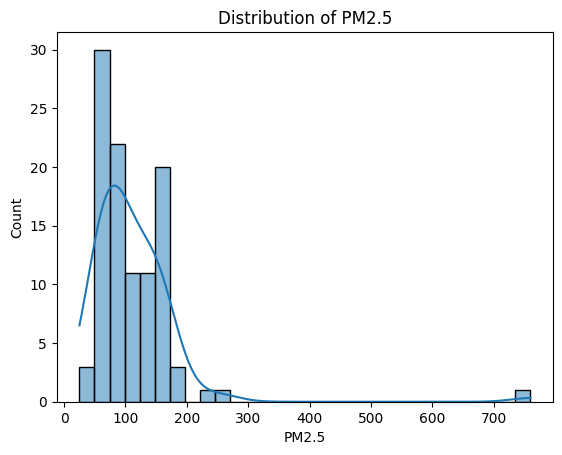

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

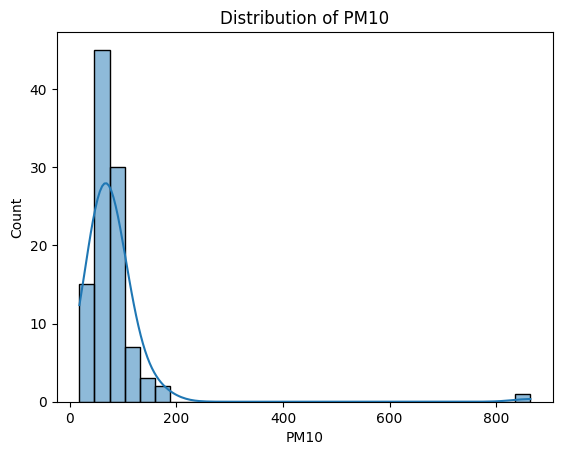

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

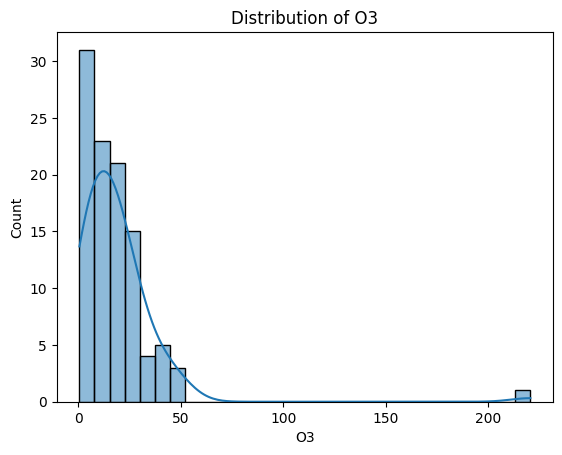

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

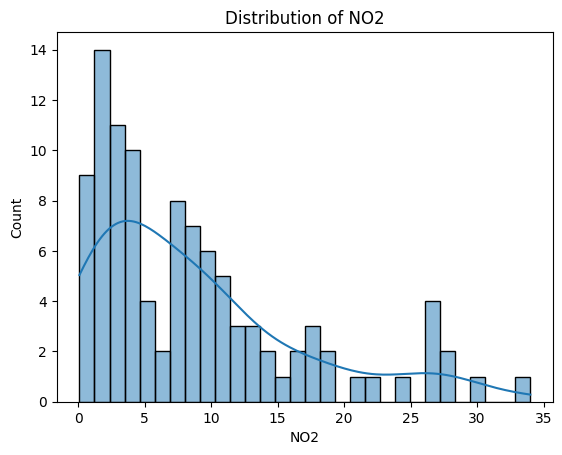

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

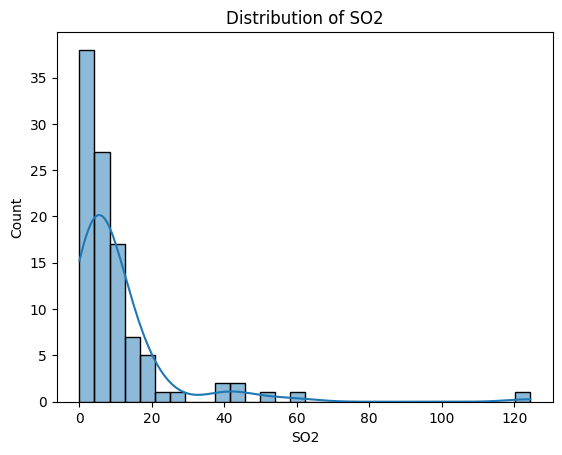

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

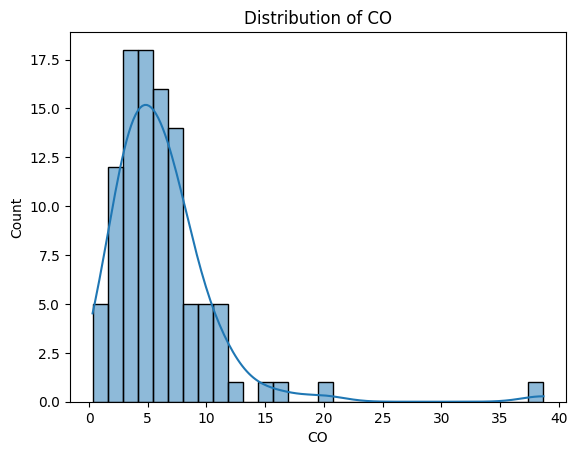

In [10]:
for col in pollutant_cols:
    plt.figure(figure=(6,4))
    sns.histplot(air_aware_data[col] , bins = 30 , kde = True)
    plt.title(f'Distribution of {col}')
    plt.show()
    

In [11]:
# Feature Scaling

In [12]:
# Scale all numeric pollutant columns between 0 and 1
scaler = MinMaxScaler()
air_aware_data[pollutant_cols] = scaler.fit_transform(air_aware_data[pollutant_cols])

print("Scaled data sample:\n", air_aware_data.head())

<IPython.core.display.Javascript object>

Scaled data sample:
                                             City       AQI     PM2.5  \
0                    Gulzarpet, Anantapur, India  0.087059  0.085714   
1  Anand Kala Kshetram, Rajamahendravaram, India  0.051765  0.044898   
2                Tirumala-APPCB, Tirupati, India  0.112941  0.115646   
4                  Naharlagun, Naharlagun, India  0.045882  0.038095   
5                    Pan Bazaar, Guwahati, India  0.108235  0.089796   

       PM10        O3       NO2       SO2        CO   Latitude  Longitude  \
0  0.062648  0.117219  0.132743  0.018504  0.161458  14.675886  77.593027   
1  0.031915  0.064062  0.351032  0.054706  0.166667  16.987287  81.736318   
2  0.041371  0.065879  0.404130  0.013677  0.226562  13.670000  79.350000   
4  0.000000  0.002272  0.029499  0.012068  0.054687  27.103358  93.679645   
5  0.104019  0.029986  0.047198  0.204344  0.145833  26.187500  91.744194   

                  Time  
0  2024-05-04 18:00:00  
1  2024-05-04 18:00:00  
2  2024-

In [13]:
# Features and target
X = air_aware_data[['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']]
y = air_aware_data['AQI']

print("Feature sample:\n", X.head())
print("Target sample:\n", y.head())

Feature sample:
       PM2.5      PM10        O3       NO2       SO2        CO
0  0.085714  0.062648  0.117219  0.132743  0.018504  0.161458
1  0.044898  0.031915  0.064062  0.351032  0.054706  0.166667
2  0.115646  0.041371  0.065879  0.404130  0.013677  0.226562
4  0.038095  0.000000  0.002272  0.029499  0.012068  0.054687
5  0.089796  0.104019  0.029986  0.047198  0.204344  0.145833
Target sample:
 0    0.087059
1    0.051765
2    0.112941
4    0.045882
5    0.108235
Name: AQI, dtype: float64


In [14]:
air_aware_data.to_csv("cleaned_air_aware_data.csv", index=False)

In [15]:
# Load your cleaned dataset
air_aware_data= pd.read_csv("C:/Users/Dell/Downloads/Infosys classes/cleaned_air_aware_data.csv")

air_aware_data.head()

<IPython.core.display.Javascript object>

,City,AQI,PM2.5,PM10,O3,NO2,SO2,CO,Latitude,Longitude,Time
0,"Gulzarpet, Anantapur, India",0.087059,0.085714,0.062648,0.117219,0.132743,0.018504,0.161458,14.675886,77.593027,2024-05-04 18:00:00
1,"Anand Kala Kshetram, Rajamahendravaram, India",0.051765,0.044898,0.031915,0.064062,0.351032,0.054706,0.166667,16.987287,81.736318,2024-05-04 18:00:00
2,"Tirumala-APPCB, Tirupati, India",0.112941,0.115646,0.041371,0.065879,0.404130,0.013677,0.226562,13.670000,79.350000,2024-05-04 18:00:00
3,"Naharlagun, Naharlagun, India",0.045882,0.038095,0.000000,0.002272,0.029499,0.012068,0.054687,27.103358,93.679645,2024-05-04 09:00:00
4,"Pan Bazaar, Guwahati, India",0.108235,0.089796,0.104019,0.029986,0.047198,0.204344,0.145833,26.187500,91.744194,2024-05-04 18:00:00


In [16]:
# STEP 3 : EXPLORING THE DATA

In [17]:
# Basic stats
print(air_aware_data.describe())

# Check for missing values
print(air_aware_data.isnull().sum())

# Handle missing data if any
air_aware_data = air_aware_data.fillna(method='ffill')

              AQI       PM2.5        PM10          O3         NO2         SO2  \
count  103.000000  103.000000  103.000000  103.000000  103.000000  103.000000   
mean     0.118275    0.118050    0.073860    0.080744    0.254776    0.082981   
std      0.103572    0.106611    0.098060    0.106951    0.233068    0.125436   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.065882    0.061224    0.043735    0.025443    0.075221    0.029364   
50%      0.092941    0.089796    0.056738    0.064062    0.203540    0.042639   
75%      0.160588    0.166667    0.079787    0.104271    0.337758    0.087289   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               CO    Latitude   Longitude  
count  103.000000  103.000000  103.000000  
mean     0.153418   23.102884   80.406236  
std      0.121090    6.189839    5.606724  
min      0.000000    8.514909   72.591912  
25%      0.087240   19.992429   76.133182  
50%   

C:\Users\Dell\AppData\Local\Temp\ipykernel_19872\3342228438.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  air_aware_data = air_aware_data.fillna(method='ffill')


In [18]:
# STEP 4: SPLITTING THE DATA INTO TRAIN AND TEST DATA

In [19]:
# Select features and target
X = air_aware_data[['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']]
y = air_aware_data['AQI']

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Scale features for models that need normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# STEP 5: BUILDING EACH MODEL

In [21]:
# STEP 5.1: BUILDING ARIMA MODEL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare AQI as time series
aqi_series = air_aware_data['AQI'].fillna(method='ffill')

# Split into train and test (80-20)
train_size = int(len(aqi_series) * 0.8)
train, test = aqi_series[:train_size], aqi_series[train_size:]

# Build and fit ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Forecast
forecast_arima = arima_fit.forecast(steps=len(test))

# Evaluate
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mae_arima = mean_absolute_error(test, forecast_arima)
print("ARIMA -> MAE:", mae_arima, " RMSE:", rmse_arima)

C:\Users\Dell\AppData\Local\Temp\ipykernel_19872\1210700943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aqi_series = air_aware_data['AQI'].fillna(method='ffill')


ARIMA -> MAE: 0.04391701452324597  RMSE: 0.05272041136015657


In [22]:
# STEP 5.2: BUILDING PROPHET MODEL
from prophet import Prophet

# Create Prophet-compatible dataframe
prophet_df = air_aware_data.copy()
prophet_df['ds'] = pd.date_range(start='2020-01-01', periods=len(prophet_df), freq='D')
prophet_df['y'] = prophet_df['AQI']

# Split train and test
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

# Build Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Forecast for the test period
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast_prophet = prophet_model.predict(future)

# Extract forecasted values
y_pred_prophet = forecast_prophet['yhat'][-len(test_prophet):]

# Evaluate
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], y_pred_prophet))
mae_prophet = mean_absolute_error(test_prophet['y'], y_pred_prophet)
print("Prophet -> MAE:", mae_prophet, " RMSE:", rmse_prophet)

<IPython.core.display.Javascript object>

01:02:36 - cmdstanpy - INFO - Chain [1] start processing
01:02:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> MAE: 0.054365144500240006  RMSE: 0.06407709710496219


In [23]:
# STEP 5.3: BUILDING XGBOOST MODEL
from xgboost import XGBRegressor

# Build and train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("XGBoost -> MAE:", mae_xgb, " RMSE:", rmse_xgb)

XGBoost -> MAE: 0.007829376031704643  RMSE: 0.011022020524028554


In [24]:
# STEP 5.4: BUILDING LSTM MODEL


In [25]:
# Load and Preprocess the Dataset
from tensorflow.keras.callbacks import EarlyStopping


In [26]:
# Example: Use your Air Quality DataFrame
df = air_aware_data.copy()

# Choose target variable (AQI or PM2.5)
target_col = 'AQI'

# Fill missing values
df = df.fillna(method='ffill')

# Normalize the target feature for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target_col]])

C:\Users\Dell\AppData\Local\Temp\ipykernel_19872\2840062389.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


<IPython.core.display.Javascript object>

In [27]:
# Create Time Series Sequences
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Use 24-hour window (or choose any lag)
time_steps = 24
X, y = create_sequences(scaled_data, time_steps)

# Split into train and test sets (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [29]:
# Build the LSTM Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the Model
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

y_pred = lstm_model.predict(X_test)

# Inverse transform to get original AQI values
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("LSTM -> MAE:", mae_lstm, " RMSE:", rmse_lstm)

Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 808ms/step - loss: 0.0321 - val_loss: 0.0082
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0186 - val_loss: 0.0058
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0262 - val_loss: 0.0038
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0143 - val_loss: 0.0024
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0132 - val_loss: 0.0020
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0222 - val_loss: 0.0026
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0224 - val_loss: 0.0031
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0229 - val_loss: 0.0028
Epoch 9/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0220 - val_loss: 0.0024
Epoch 10/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0138 - val_loss: 0.0021
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
LSTM -> MAE: 0.04071919876096002  RMSE: 0.046414942973220796


In [31]:
# ----- Compare All Models -----
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'LSTM', 'XGBoost'],
    'MAE': [mae_arima, mae_prophet, mae_lstm, mae_xgb],
    'RMSE': [rmse_arima, rmse_prophet,rmse_lstm, rmse_xgb]
})

print("\n📊 Model Comparison:")
print(results)

best_model = results.loc[results['RMSE'].idxmin(), 'Model']
print(f"\n✅ Best Performing Model: {best_model}")

<IPython.core.display.Javascript object>


📊 Model Comparison:
     Model       MAE      RMSE
0    ARIMA  0.043917  0.052720
1  Prophet  0.054365  0.064077
2     LSTM  0.040719  0.046415
3  XGBoost  0.007829  0.011022

✅ Best Performing Model: XGBoost


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

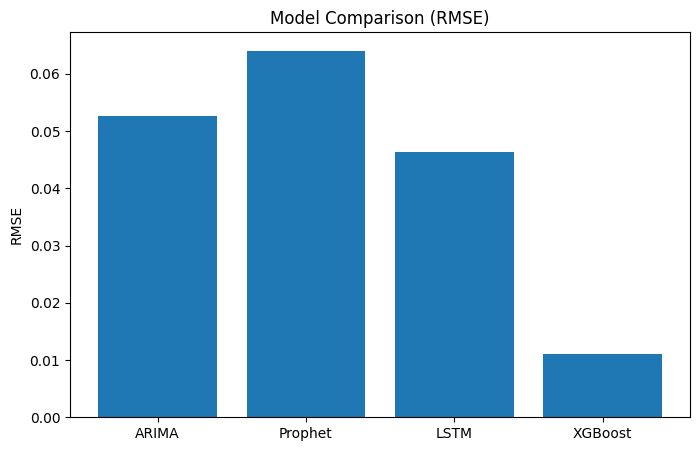

In [32]:
plt.figure(figsize=(8,5))
models = ['ARIMA', 'Prophet', 'LSTM', 'XGBoost']
rmses = [rmse_arima, rmse_prophet, rmse_lstm, rmse_xgb]
plt.bar(models, rmses)
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

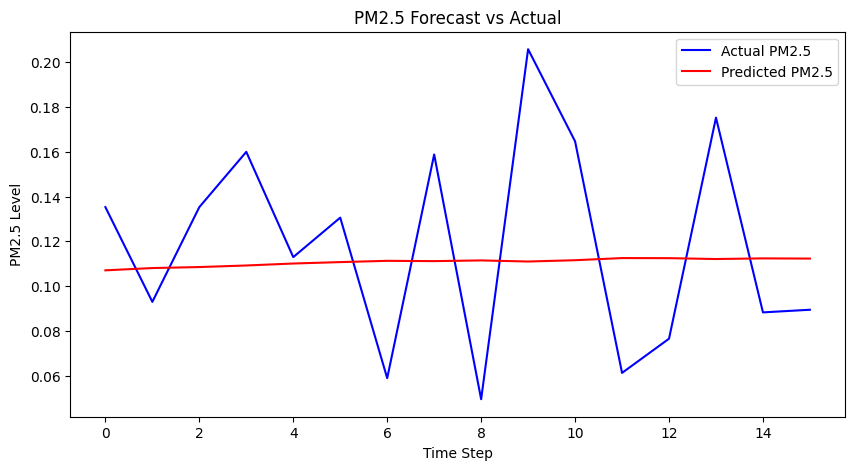

In [35]:
# Plot Forecast vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual PM2.5', color='blue')
plt.plot(y_pred_inv, label='Predicted PM2.5', color='red')
plt.title('PM2.5 Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.show()


In [36]:
# Train Per-City Models

In [37]:
# Define number of time steps again for this cell
n_steps = 10  

cities = air_aware_data['City'].unique()
for city in cities:
    print(f"\nTraining model for {city}...")
    
    # Filter data for one city
    city_data = air_aware_data[air_aware_data['City'] == city]
    
    # Skip if city has too little data
    if len(city_data) < n_steps + 10:
        print(f"Skipping {city} (not enough data)")
        continue
    
    # Scale features
    city_scaled = scaler.fit_transform(city_data[['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']])
    
    # Create sequences
    X_city, y_city = create_sequences(city_scaled, n_steps)
    
    # Split city data into train/test
    split_idx = int(len(X_city) * 0.8)
    X_train_city, X_test_city = X_city[:split_idx], X_city[split_idx:]
    y_train_city, y_test_city = y_city[:split_idx], y_city[split_idx:]
    
    # Build a new model for each city
    city_model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, X_city.shape[2])),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    
    city_model.compile(optimizer='adam', loss='mse')
    
    # Train model
    city_model.fit(X_train_city, y_train_city, epochs=20, batch_size=16, verbose=0)
    
    # Evaluate
    city_loss = city_model.evaluate(X_test_city, y_test_city, verbose=0)
    print(f"{city} model loss: {city_loss:.4f}")
    
    # Save model
    city_model.save(f"model_{city}.h5")



Training model for Gulzarpet, Anantapur, India...
Skipping Gulzarpet, Anantapur, India (not enough data)

Training model for Anand Kala Kshetram, Rajamahendravaram, India...
Skipping Anand Kala Kshetram, Rajamahendravaram, India (not enough data)

Training model for Tirumala-APPCB, Tirupati, India...
Skipping Tirumala-APPCB, Tirupati, India (not enough data)

Training model for Naharlagun, Naharlagun, India...
Skipping Naharlagun, Naharlagun, India (not enough data)

Training model for Pan Bazaar, Guwahati, India...
Skipping Pan Bazaar, Guwahati, India (not enough data)

Training model for D M Colony, Bihar Sharif, India...
Skipping D M Colony, Bihar Sharif, India (not enough data)

Training model for New DM Office, Arrah, India...
Skipping New DM Office, Arrah, India (not enough data)

Training model for DRCC Anandpur, Begusarai, India...
Skipping DRCC Anandpur, Begusarai, India (not enough data)

Training model for Kamalnath Nagar, Bettiah, India...
Skipping Kamalnath Nagar, Bettiah